# Time Series Anaysis
Time Series are a sequence of data points ordered in time. Each data point contains one or more values and also has a time stamp. For instance, the average daily temperature is a time series. Time Series Analysis (TSA) is studying the behaviour of time series. 

An important part of time series analysis (TSA) is time series forcasting (TSF) which is using a sequence of data to predict future behaviour. In this session we will discuss TSA, and tool and technques in TSA. The next session will be focused on forcasting.


TSA has its own unique vocabulary and technical terms. Throughout this notebook we will explain some of these terms and what they mean in practice.


## Tools

One of the main tools for TSA is __Pandas__. In previous notebooks we learned about Pandas and it's capabilities in reading, writing, and manipulating tabular data. Pandas also has a wide range of functionalities for TSA. 

Another common tool for TSA in python is __Statsmodels__. Statsmodels is library with wide range of statistical analysis tools and a sub-module dedicated to TSA.

In [1]:
# Our main packages for TSA
import pandas as pd

# For math and array operations
import numpy as np

# For plotting
import matplotlib.pyplot as plt

Later, we will import statsmodels sub-modules as we need them.

## Pandas for time series

Pandas has functionalities for reading time and date. 

In [2]:
data_normal = pd.read_csv("../../data/processed/Generated/SampleSales.csv")
data_normal["Date"]

0      2014-11-08
1      2014-11-20
2      2014-12-01
3      2014-12-15
4      2014-12-15
          ...    
924    2017-04-25
925    2017-04-25
926    2017-04-25
927    2017-04-25
928    2017-04-26
Name: Date, Length: 929, dtype: object

When reading data that contains date/time we can ask pandas to parse it as datetimes with `parse_dates = ['Column_name']`.

In [3]:
data_date_parsed = pd.read_csv(
    "../../data/processed/Generated/SampleSales.csv", parse_dates=["Date"]
)
data_date_parsed["Date"]

0     2014-11-08
1     2014-11-20
2     2014-12-01
3     2014-12-15
4     2014-12-15
         ...    
924   2017-04-25
925   2017-04-25
926   2017-04-25
927   2017-04-25
928   2017-04-26
Name: Date, Length: 929, dtype: datetime64[ns]

In the first scenario when we print 'Date' column at the bottom it prints `dtype = object` which in this case it means pandas understands the dates as a string (or text). It has no understanding of what the dates actually mean. But in the second scenario, the type is `datetime64[ns]` which is a date/time object with accuracy of nanoseconds. Now pandas knows these are dates and it knows the year, month, day, etc. Also, despite showing only year, month, and day it is saving it to nanoseconds accuracy, which means we could also have time of the day included as well.


Also, by passing `index_col = 'Date'` we can let pandas know that in the index column, instead of using numbers (0, 1, 2, ...) use the _'Date'_ column. This will make it easier to access data based on date.

In [4]:
data_index_parsed = pd.read_csv(
    "../../data/processed/Generated/SampleSales.csv",
    parse_dates=["Date"],
    index_col=["Date"],
)

In [5]:
# Notice freq is none, that makes sense since we don't have values for every day
data_index_parsed.index

DatetimeIndex(['2014-11-08', '2014-11-20', '2014-12-01', '2014-12-15',
               '2014-12-15', '2014-12-19', '2014-12-21', '2014-12-24',
               '2014-12-30', '2015-01-01',
               ...
               '2017-04-24', '2017-04-24', '2017-04-25', '2017-04-25',
               '2017-04-25', '2017-04-25', '2017-04-25', '2017-04-25',
               '2017-04-25', '2017-04-26'],
              dtype='datetime64[ns]', name='Date', length=929, freq=None)

<AxesSubplot:xlabel='Date'>

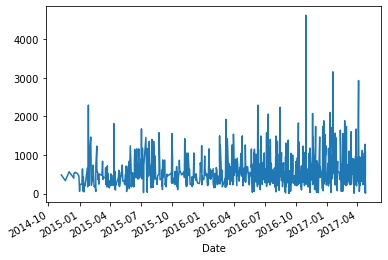

In [6]:
data_index_parsed['Total'].plot()

In [7]:
data_index_parsed

,Total
Date,
2014-11-08,482.839269
2014-11-20,335.725804
2014-12-01,566.417526
2014-12-15,401.477256
2014-12-15,518.200174
...,...
2017-04-25,383.419262
2017-04-25,324.312800
2017-04-25,1001.466937


Now we can get the data for a certain date or time period. Let stick to the ISO format which is year-month-day, this sidesteps the confusion over US vs UK date formats.

In [8]:
data_index_parsed.loc["2014-12-19"]

Total    553.87814
Name: 2014-12-19 00:00:00, dtype: float64

In [9]:
data_index_parsed.loc["2014-11-01":"2014-12-01"]

,Total
Date,
2014-11-08,482.839269
2014-11-20,335.725804
2014-12-01,566.417526


Also, if you have an array of dates in string format you can use `.to_datetime()` to convert it to datetime object. The date string can be in many formats and pandas can usually figure it out.

In [10]:
pd.to_datetime(["1/3/2019", "July 23rd, 1964", "2006-01-09"])

DatetimeIndex(['2019-01-03', '1964-07-23', '2006-01-09'], dtype='datetime64[ns]', freq=None)

Or you can specify which format pandas should use.

In [11]:
pd.to_datetime(["1/3/2019"], format="%d/%m/%Y")

DatetimeIndex(['2019-03-01'], dtype='datetime64[ns]', freq=None)

In [12]:
pd.to_datetime(["1/3/2019"], format="%m/%d/%Y")

DatetimeIndex(['2019-01-03'], dtype='datetime64[ns]', freq=None)

## Resampling
There are times you might need weekly data but you have it on daily basis. You can use resampling to transform the data into the new time intervals. This is also useful when you are dealing with datapoints which are not equally spaced. Let's have another look at the data we loaded earlier.

In [13]:
data_index_parsed.head(10)

,Total
Date,
2014-11-08,482.839269
2014-11-20,335.725804
2014-12-01,566.417526
2014-12-15,401.477256
2014-12-15,518.200174
2014-12-19,553.878140
2014-12-21,533.135254
2014-12-24,535.213187
2014-12-30,457.167255


This data shows the time and amount of purchases from a shop. The purchases are not taking place on a fixed interval. They can happen anytime. We can resample this data into weekly sales which makes it easier to analyse. To do this, we need to use the `.resample()` method and pass in the new interval. After that we need to specify how we want the data in each interval to be aggregated. In this case, we choose the sum function because we want the total sales in each week.

In [14]:
df = data_index_parsed.resample("W").sum()
df.head(10)

,Total
Date,
2014-11-09,482.839269
2014-11-16,0.000000
2014-11-23,335.725804
2014-11-30,0.000000
2014-12-07,566.417526
2014-12-14,0.000000
2014-12-21,2006.690823
2014-12-28,535.213187
2015-01-04,760.333201


Now we have weekly sales. Note that we passed in "W" to convert the data into weekly sales. There are a range of options available in pandas for various intervals. The table below shows a range of options for resampling.<br>
Note that not all the options on the table below are applicable for resampling. The options for resampling are "M", "A", "Q", "BM", "BA", "BQ", and "W". The other options in the table have other application which we will discuss later.

DateOffsets and their frequency strings. ([Source](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects))<br>

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Date Offset</th>
      <th>Frequency String</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>DateOffset</td>
      <td>None</td>
      <td>Generic offset class, defaults to 1 calendar day</td>
    </tr>
    <tr>
      <td>BDay or BusinessDay</td>
      <td>'B'</td>
      <td>business day (weekday)</td>
    </tr>
    <tr>
      <td>CDay or CustomBusinessDay</td>
      <td>'C'</td>
      <td>custom business day</td>
    </tr>
    <tr>
      <td>Week</td>
      <td>'W'</td>
      <td>one week, optionally anchored on a day of the week</td>
    </tr>
    <tr>
      <td>WeekOfMonth</td>
      <td>'WOM'</td>
      <td>the x-th day of the y-th week of each month</td>
    </tr>
    <tr>
      <td>LastWeekOfMonth</td>
      <td>'LWOM'</td>
      <td>the x-th day of the last week of each month</td>
    </tr>
    <tr>
      <td>MonthEnd</td>
      <td>'M'</td>
      <td>calendar month end</td>
    </tr>
    <tr>
      <td>MonthBegin</td>
      <td>'MS'</td>
      <td>calendar month begin</td>
    </tr>
    <tr>
      <td>BMonthEnd or BusinessMonthEnd</td>
      <td>'BM'</td>
      <td>business month end</td>
    </tr>
    <tr>
      <td>BMonthBegin or BusinessMonthBegin</td>
      <td>'BMS'</td>
      <td>business month begin</td>
    </tr>
    <tr>
      <td>CBMonthEnd or CustomBusinessMonthEnd</td>
      <td>'CBM'</td>
      <td>custom business month end</td>
    </tr>
    <tr>
      <td>CBMonthBegin or CustomBusinessMonthBegin</td>
      <td>'CBMS'</td>
      <td>custom business month begin</td>
    </tr>
    <tr>
      <td>SemiMonthEnd</td>
      <td>'SM'</td>
      <td>15th (or other day_of_month) and calendar month end</td>
    </tr>
    <tr>
      <td>SemiMonthBegin</td>
      <td>'SMS'</td>
      <td>15th (or other day_of_month) and calendar month begin</td>
    </tr>
    <tr>
      <td>QuarterEnd</td>
      <td>'Q'</td>
      <td>calendar quarter end</td>
    </tr>
    <tr>
      <td>QuarterBegin</td>
      <td>'QS'</td>
      <td>calendar quarter begin</td>
    </tr>
    <tr>
      <td>BQuarterEnd</td>
      <td>'BQ</td>
      <td>business quarter end</td>
    </tr>
    <tr>
      <td>BQuarterBegin</td>
      <td>'BQS'</td>
      <td>business quarter begin</td>
    </tr>
    <tr>
      <td>FY5253Quarter</td>
      <td>'REQ'</td>
      <td>retail (aka 52-53 week) quarter</td>
    </tr>
    <tr>
      <td>YearEnd</td>
      <td>'A'</td>
      <td>calendar year end</td>
    </tr>
    <tr>
      <td>YearBegin</td>
      <td>'AS' or 'BYS'</td>
      <td>calendar year begin</td>
    </tr>
    <tr>
      <td>BYearEnd</td>
      <td>'BA'</td>
      <td>business year end</td>
    </tr>
    <tr>
      <td>BYearBegin</td>
      <td>'BAS'</td>
      <td>business year begin</td>
    </tr>
    <tr>
      <td>FY5253</td>
      <td>'RE'</td>
      <td>retail (aka 52-53 week) year</td>
    </tr>
    <tr>
      <td>Easter</td>
      <td>None</td>
      <td>Easter holiday</td>
    </tr>
    <tr>
      <td>BusinessHour</td>
      <td>'BH'</td>
      <td>business hour</td>
    </tr>
    <tr>
      <td>CustomBusinessHour</td>
      <td>'CBH'</td>
      <td>custom business hour</td>
    </tr>
    <tr>
      <td>Day</td>
      <td>'D'</td>
      <td>one absolute day</td>
    </tr>
    <tr>
      <td>Hour</td>
      <td>'H'</td>
      <td>one hour</td>
    </tr>
    <tr>
      <td>Minute</td>
      <td>'T' or 'min'</td>
      <td>one minute</td>
    </tr>
    <tr>
      <td>Second</td>
      <td>'S'</td>
      <td>one second</td>
    </tr>
    <tr>
      <td>Milli</td>
      <td>'L' or 'ms'</td>
      <td>one millisecond</td>
    </tr>
    <tr>
      <td>Micro</td>
      <td>'U' or 'us'</td>
      <td>one microsecond</td>
    </tr>
    <tr>
      <td>Nano</td>
      <td>'N'</td>
      <td>one nanosecond</td>
    </tr>
  </tbody>
</table>


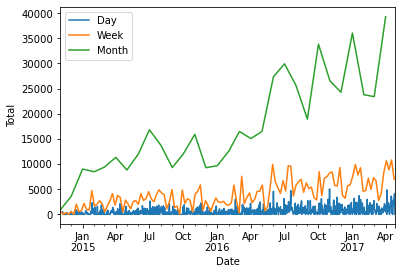

In [15]:
# Lets compare differen't resamplings
ax=plt.gca()
data_index_parsed['Total'].resample("D").sum().plot(label="Day", ax=ax)
data_index_parsed['Total'].resample("W").sum().plot(label="Week", ax=ax)
data_index_parsed['Total'].resample("M").sum().plot(label="Month", ax=ax)
plt.ylabel('Total')
plt.legend()

## Shifting
Shifiting is moving the data forward or backward in time. For instance, the code below shifts the data one week to the future.

In [16]:
# Pandas knows the interval is a week
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 130 entries, 2014-11-09 to 2017-04-30
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Total   130 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB


In [17]:
df.head()

,Total
Date,
2014-11-09,482.839269
2014-11-16,0.000000
2014-11-23,335.725804
2014-11-30,0.000000
2014-12-07,566.417526


In [18]:
df.shift(periods=1)

,Total
Date,
2014-11-09,NaN
2014-11-16,482.839269
2014-11-23,0.000000
2014-11-30,335.725804
2014-12-07,0.000000
...,...
2017-04-02,4161.651045
2017-04-09,8315.345132
2017-04-16,10651.060072


Notice the value that belonged to "2014-11-09" now belongs to "2014-11-09". Also, you can see in the first row since there was no data point to be moved there, its new value is `NaN`.<br>
Now the question is how does pandas know how much it should shift the data? In other words, why did it decide to move the data one week and not one day? The answer is because pandas knows our data is weekly, so when we asked it to shift the data by one period it assumed one week. This is called the frequency of the data and we can check it using `.info()` as we did above.

The frequency is "W-SUN" which means weekly data and each week starts at sunday.

__What if we want Monday to be start of the week?__<br>
When we were resampling the data we asked pandas to create weekly data. We can specify which day should start of the week.

In [19]:
data_index_parsed.resample("W-MON").sum()

,Total
Date,
2014-11-10,482.839269
2014-11-17,0.000000
2014-11-24,335.725804
2014-12-01,566.417526
2014-12-08,0.000000
...,...
2017-04-03,7784.433972
2017-04-10,10386.535786
2017-04-17,11560.698904


__What if we only wanted to shift the data one day and not one week?__<br>
We can specify a frequency when shifting.

In [20]:
df.shift(periods=1, freq="D")

,Total
Date,
2014-11-10,482.839269
2014-11-17,0.000000
2014-11-24,335.725804
2014-12-01,0.000000
2014-12-08,566.417526
...,...
2017-04-03,8315.345132
2017-04-10,10651.060072
2017-04-17,8838.054915


Note in the above example only the dates changed and `NaN` didn't appear in the first row.

We can also shift backward. If we do this, `NaN` will appear at the end of the data.

In [21]:
df.shift(-2)

,Total
Date,
2014-11-09,335.725804
2014-11-16,0.000000
2014-11-23,566.417526
2014-11-30,0.000000
2014-12-07,2006.690823
...,...
2017-04-02,8838.054915
2017-04-09,10798.307952
2017-04-16,6952.748452


## Rolling
Rolling is applying a function to a number of consecutive data points. For instance, at each point in time we take the average of the past 4 weeks. Taking average of past few periods is also know as __Moving Average Smoothing__.<br>
We first need to select the window (how many values we should consider), and then apply an aggregation function. (e.g. mean, sum, etc.)


<img width="300" src="img/timeseries-resample-windows.png"/>
</br>
<img width="400" src="img/timeseries-rolling-windows.png"/>

In [22]:
df.rolling(window=4).mean()

,Total
Date,
2014-11-09,NaN
2014-11-16,NaN
2014-11-23,NaN
2014-11-30,204.641268
2014-12-07,225.535833
...,...
2017-04-02,5477.888418
2017-04-09,6471.664983
2017-04-16,7991.527791


__Note:__ Since the first three points didn't have three instances before them, the moving average was not calculated for them.

Let's save the moving average in the same data frame and plot the result to better understand why we would do this.

<AxesSubplot:xlabel='Date'>

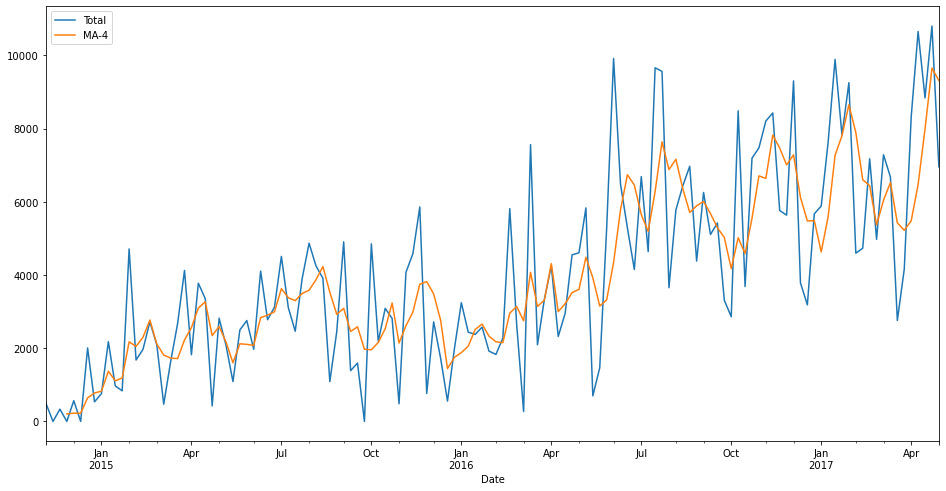

In [23]:
df["MA-4"] = df.rolling(window=4).mean()  # MA-4 for moving average of size 4 window
df.plot(y=["Total", "MA-4"], figsize=(16, 8))

Let's try a larger window size. Because now we have two columns in the data, we need to specify which column we are taking a moving average of.

<AxesSubplot:xlabel='Date'>

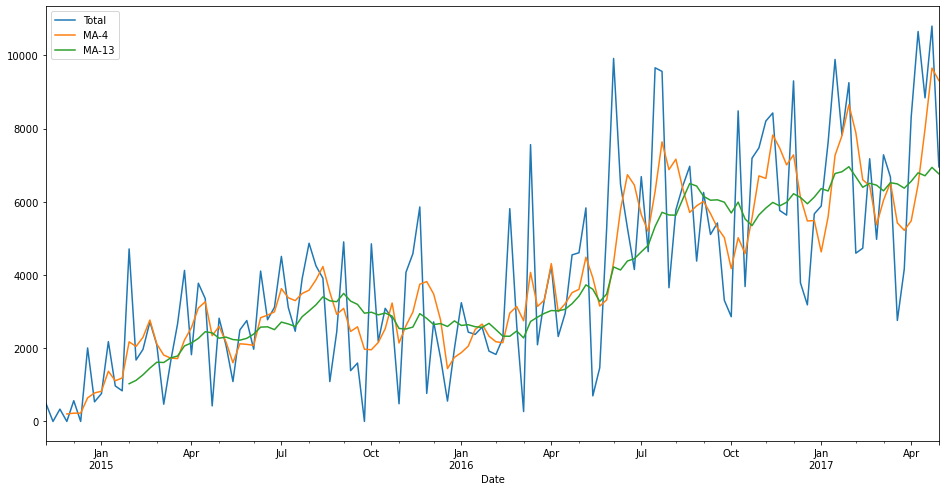

In [24]:
df["MA-13"] = (
    df["Total"].rolling(window=13).mean()
)  # MA-4 for moving average of size 4 window
df.plot(y=["Total", "MA-4", "MA-13"], figsize=(16, 8))

As the name suggests __Moving Average Smoothing__ creates a smoothed out version of the data. The larger the window size, smoother the data will be. This is helpful when we want to get rid of noise in the data so we can have a better look at the trends. However, noise reduction comes at a cost. The downside of using moving average is the it creates lag in the data. For instance if there is a sudden increase in the data moving average responds to this change slower. It also doesn't reach the peaks of the original data. In the plot above you can see that "MA-13" does not show the high and low values of the data but only follows th main trend.

Another useful function pandas provide is **expanding**. While at each point rolling applied a function over a fixed window, expanding applies a function over all the points that came before that specific point. For instance, if we apply mean function at 10th point we will have the average of first 10 points and at 20th point we will have the average of first 20 points.

exanding().sum() is the same as .cumsum()


<AxesSubplot:xlabel='Date'>

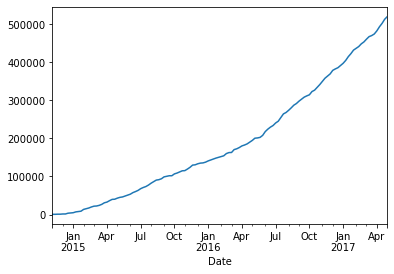

In [25]:
df["Total"].expanding().sum().plot()

<AxesSubplot:xlabel='Date'>

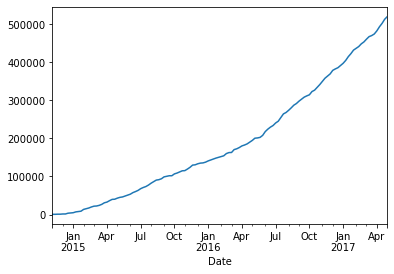

In [26]:
# exanding().sum() is the same as .cumsum(), but you can use operations other than sum
df["Total"].cumsum().plot()

<div class="alert alert-success">
  <h2>Exercise</h2>

Here's an exercise to get you familiar with the Pandas docs on timeseries.

You need to change the timezone on a dataframe but your not sure how. 
    
- Look through [the dataframe docs](https://pandas.pydata.org/docs/reference/frame.html) and find how to set a timezone on a series that doesn't have one (but you know it's 'Australia/Perth')
- Set it to 'Australia/Perth'
- plot it


  <details>
  <summary><b>→ Hints</b></summary>

  * Start in the Time-Series related section
  * Scan it, then Ctrl-F for `timezone`
  * Jargon is `localize` a `tz naive` series

  </details>

  <br/>
  <br/>
  <details>
  <summary>
    <b>→ Solution</b>
  </summary>

  ```python
  # DataFrame.tz_localize
  df.tz_localize('Australia/Perth').plot(
  ```

  </details>

  </div>

Other operations:
    
- https://pandas.pydata.org/pandas-docs/stable/reference/general_functions.html#top-level-dealing-with-datetimelike
- https://pandas.pydata.org/pandas-docs/stable/reference/frame.html#time-series-related
- https://pandas.pydata.org/pandas-docs/stable/reference/series.html#time-series-related

## Lowess Smoothing
Now that we learned about moving average smoothing, let's discuss another technique. Locally weighted scatterplot smoothing (LOWESS) is another technique for smoothing. 

Lowess creates local models for small subsets of data and uses a weighted average of them for smoothing. 


In [27]:
# The implementation of Lowess in statsmodels can be found in nonparametric sub-module.
from statsmodels.nonparametric.smoothers_lowess import lowess

To create a smoothed output it requires x and y values. For time series x would be the time dimension and y would be the values.

<AxesSubplot:xlabel='Date'>

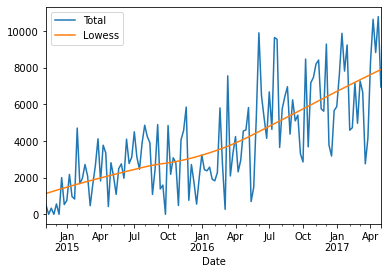

In [28]:
x = df.index
y = df["Total"]
result = lowess(y, x)
df["Lowess"] = result[
    :, 1
]  # Lowess returns x and y. The second column (column index 1) are the values we need.
df.plot(y=["Total", "Lowess"])

## Time Series Decomposition

The goal of decomposition is to break down time series into different elements each describing a specific behaviour of data.

### STL Decomposition

Seasonal-Trend decomposition with LOESS (STL) is another method for decomposition of time series. This method breaks down the data into three elements:
1. Trend
2. Seasonality
3. Residual (Error or Noise)

We learned about LOWESS for smoothing (LOESS is a similar method with only minor differences). LOESS showed the capability to extract the trend of time series. By removing the trend from the data STL assumes the remainder is sum of a seasonal component and some residual. Seasonal component is the repeating pattern of data. The sort of behaviour that repeats weekly, monthly, etc.<br>STL can decompose the time serie in two ways. First is additive method, where the original data is sum of its components:
$$y_t = \tau_t + s_t + r_t $$
Second, the multiplicative approach where the data is product of its components:
$$y_t = \tau_t \times s_t \times r_t $$
Statsmodel has a function for STL called `seasonal_decompose`.

In [29]:
# This data shows the number of customers a retail shop had per months
cust = pd.read_csv(
    "../../data/processed/Generated/Customers.csv", parse_dates=True, index_col="Month"
)
cust.head()

,Customers
Month,
1994-01-01,412
1994-02-01,406
1994-03-01,456
1994-04-01,440
1994-05-01,422


Let's have quick look at the data.

<AxesSubplot:xlabel='Month'>

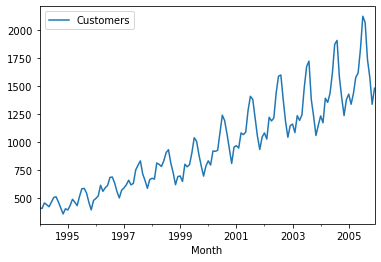

In [30]:
cust.plot(y="Customers")

We can clearly see a repeating pattern. That's called seasonality and we expect STL to be able to capture this behaviour.

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(cust["Customers"], model='additive')

Now the time serie is decomposed and we can plot the result.

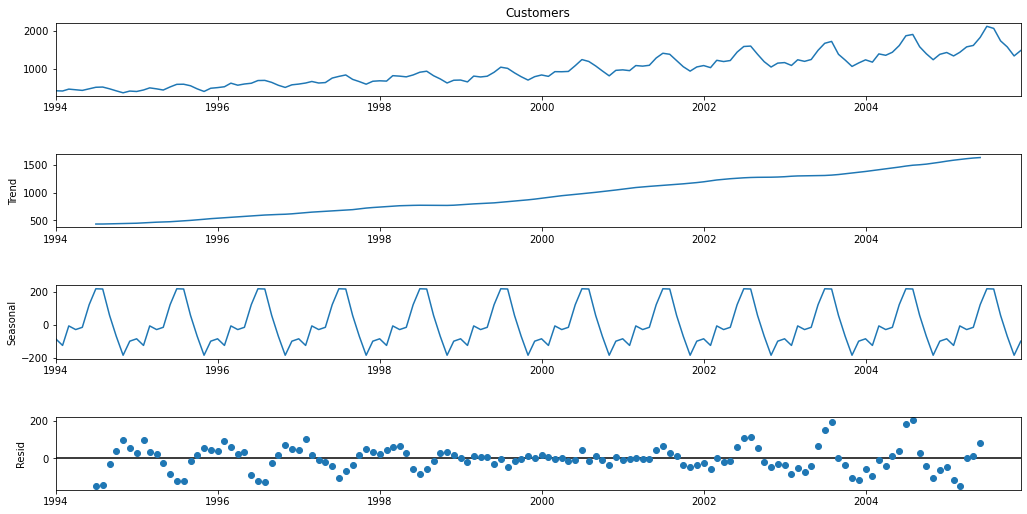

In [42]:
ax = result.plot()
ax.set_figwidth(16)
ax.set_figheight(8)

By default the model used additive approach for the data. If we want to use multiplicative approach we need to specify it in the function. But what is the difference between additive and multiplicative? Additive approach is used when the height of the repeating patterns are constant. This means the amplitude of seasonal component is not changing. But in this data we can clearly see the seasonal component is getting larger and larger. This is also visible in the residual component. The residual component is meant to look like random noise but we can clearly see some regular oscillation in there. So let's try multiplicative approach.

sum of residuals 131.76


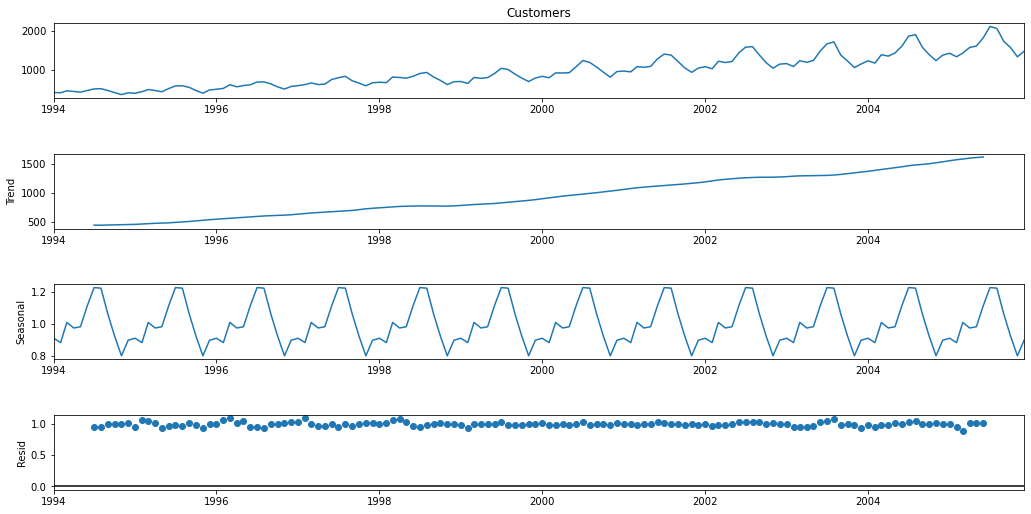

In [68]:
result = seasonal_decompose(cust["Customers"], model="multiplicative")
print(f'sum of residuals {result.resid.sum():2.2f}')
ax = result.plot()
ax.set_figwidth(16)
ax.set_figheight(8)

__Note:__ While residuals in additive model is around zero, in multiplicative model they are around one.

As we can see, multiplicative approach looks much better. There is still a bit of pattern in residuals but it has improved significantly compared to additive approach.

## Exercise
<div class="alert alert-success">

let's try these on real data, which will be much harder. Use the data below and perform the following analyses:
    
- STL decomposition using additive method.
   
<details>
<summary>Hints</summary>
    
* Find the relevent code, copy it, and change it to use `df['target']` 
</details>
</div>


,target
day,
2011-12-03,9.007
2011-12-04,20.763
2011-12-05,6.020
2011-12-06,13.322
2011-12-07,9.062
...,...
2012-03-07,9.587
2012-03-08,14.946
2012-03-09,5.205


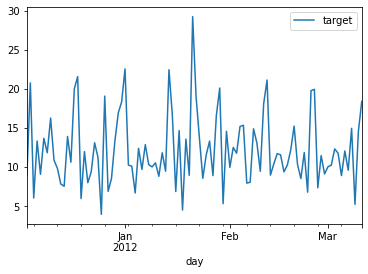

In [69]:
df = block0 = pd.read_csv("../../data/processed/smartmeter/block_0.csv", parse_dates=['day'], index_col=['day'])[['energy_sum']]
df = df.groupby('day').mean().iloc[:100]
df = df.rename(columns={'energy_sum':'target'})
df.plot()
df

In [71]:
# Exercise 1


<div class="alert alert-success">
    
### Solution
<details><summary>See solution</summary>



```Python
# Exercise 1
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['target'],model = 'add')
result.plot();
print(f'sum of residuals {result.resid.sum():2.2f}')
```

</details>
</div>

## Further Reading:
- [Pandas time-series documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)
- [Statsmodel documentation](https://www.statsmodels.org/)
- [Forecasting: Principles and Practice](https://otexts.com/fpp2/)
- [Exponential Smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing)
- [Gentle Introduction to Exponential smoothing](https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/)

